In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes
from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:07<00:00,  1.90it/s]

CPU times: user 204 ms, sys: 236 ms, total: 440 ms
Wall time: 7.9 s


## Subset of reads with at least 4 SNPs

In [5]:
%%time
dense_reads_with_detection_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        'CO_active_interval_start',
        'CO_active_interval_end',
        'CO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'CO_active_interval_start_cM',
        'CO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        "mid_CO_active_interval_crossover_prob",
        "full_read_crossover_prob",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
        "high_quality_classification_class",
        "snp_positions_on_read", 
        "idx_transitions",
        "H3K4me3_signal_mean",
        "CTCF_signal_sum",
        "CTCF_signal_mean",
        "high_quality_classification_in_detectable_class",
    )
    .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .collect(streaming=True)
)

CPU times: user 3min 16s, sys: 36 s, total: 3min 53s
Wall time: 1min 29s


# # of events, expected vs. observed

Carefully constrain the set of reads for this analysis:

* Only reads with sufficient coverage, to (over)account for the effect of filtering for coverage between switches
* Only high quality reads
* We can allow 4 SNPs

In [6]:
possible_CO_subset_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
    .filter("is_high_quality_read")
    .filter(pl.col("mid_CO_active_interval_crossover_prob") > 0)
    .filter(pl.col("min_coverage_hap1") >= 3)
    .filter(pl.col("min_coverage_hap2") >= 3)
)



In [7]:
def get_obs_exp(df):
    n_observed_COs = len(df.filter(pl.col("high_quality_classification_class") == "CO"))
    
    ps = df["mid_CO_active_interval_crossover_prob"].to_numpy()

    # Expected is \sum_{p}
    mean_expected_COs = ps.sum()

    # Variance is \sum_{p(1-p)}
    std_expected_COs = (ps*(1-ps)).sum()**0.5
    
    return {
        "n_observed_COs": n_observed_COs,
        "mean_expected_COs": mean_expected_COs,
        "std_expected_COs": std_expected_COs,
    }
    
    

In [8]:
get_obs_exp(possible_CO_subset_df)

{'n_observed_COs': 3931,
 'mean_expected_COs': 4364.967522012835,
 'std_expected_COs': 66.02706153226625}

In [9]:
get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids)))

{'n_observed_COs': 1394,
 'mean_expected_COs': 1650.2053216048942,
 'std_expected_COs': 40.598422170422666}

KeyboardInterrupt: 

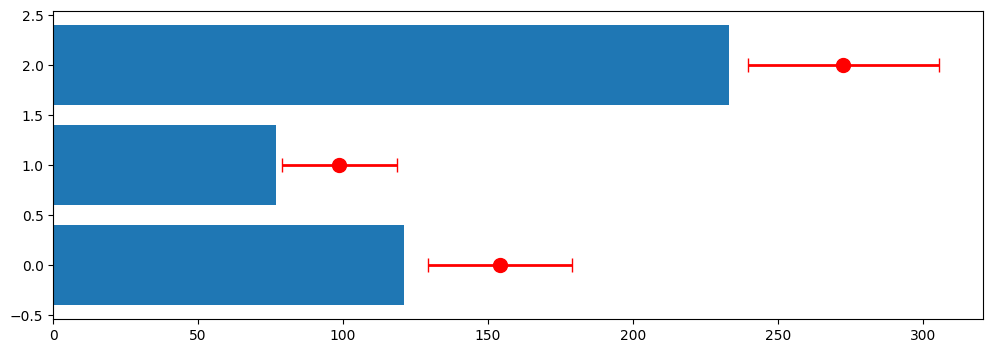

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_presentation_order[:-1]):
    d = get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id") == sample_id))
    
    ax.barh(
        y = i,
        width = d["n_observed_COs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_COs"],
        y = i,
        xerr = d["std_expected_COs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_presentation_order[:-1])), [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of CO reads");
    

# Overall rates

In [11]:
CO_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
CO_df = pl.concat(dfs)

## cM/Mb rates

### cM/Mb across CO interval

In [ ]:
(CO_df["grch37_cM_per_bp_across_recombining_interval"]*1e6).mean()

### Across all read

In [ ]:
(CO_df["full_read_crossover_prob"]*1e2 / CO_df["read_length"] * 1e6).mean()



### Compare to background

In [ ]:
(dense_reads_with_detection_df
    .select(pl.col("CO_active_interval_crossover_prob")*1e2 / pl.col("CO_active_interval_length_bp") * 1e6)
).mean()

# Does it follow the model?

## In bp

### All read

In [ ]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("read_length") // N).round() * N).alias("read_length_rounded_bp"),
        (pl.col("idx_transitions").list.len() == 1).cast(pl.Int32).alias("is_co"),
    )
    .group_by("read_length_rounded_bp")
    .agg(pl.col("is_co").mean())
    .sort("read_length_rounded_bp")
    .plot.scatter(x="read_length_rounded_bp", y="is_co")
)

### Only detectable interval

In [ ]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("CO_active_interval_length_bp") // N).round() * N).alias("detectable_interval_length_rounded_bp"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "CO")
        ).cast(pl.Int32).alias("is_co"),
    )
    .group_by("detectable_interval_length_rounded_bp")
    .agg(pl.col("is_co").mean())
    .sort("detectable_interval_length_rounded_bp")
    .plot.scatter(x="detectable_interval_length_rounded_bp", y="is_co")
)

## In cM

### All read

In [ ]:
N = 1e-1*0.5

(dense_reads_with_detection_df
    .select(
        (((pl.col("grch37_reference_end_cM") - pl.col("grch37_reference_start_cM")) // N).round() * N).alias("read_length_rounded_cM"),
        (pl.col("idx_transitions").list.len() == 1).cast(pl.Int32).alias("is_co"),
    )
    .group_by("read_length_rounded_cM")
    .agg(pl.col("is_co").mean())
    .sort("read_length_rounded_cM")
    .plot.scatter(x="read_length_rounded_cM", y="is_co")
)

### Only detectable interval

In [ ]:
N = 1e-2

(dense_reads_with_detection_df
    .select(
        (((pl.col("CO_active_interval_end_cM") - pl.col("CO_active_interval_start_cM")) // N).round() * N).alias("detectable_interval_length_rounded_cM"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "CO")
        ).cast(pl.Int32).alias("is_co"),
    )
    .group_by("detectable_interval_length_rounded_cM")
    .agg(pl.col("is_co").mean())
    .sort("detectable_interval_length_rounded_cM")
    .plot.scatter(x="detectable_interval_length_rounded_cM", y="is_co")
)

# Does it follow the CO map along the genome?

In [ ]:
def show_co_map(sample_ids, show_ks=True):
    fig, axs = plt.subplots(4, 6, figsize=(14, 10))

    kses = []
    for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
        df = (dense_reads_with_detection_df              
            .filter(pl.col("sample_id").is_in(sample_ids))
            .filter(pl.col("high_quality_classification_class") == "CO")
            .filter(pl.col("chrom") == chrom)
            .sort("grch37_reference_start_cM")
            .drop_nulls("grch37_reference_start_cM")
        )

        midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
        genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2

        ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
        kses.append(ks_pvalue)

        ax.plot(midpoints_in_cms, '.')
        ax.plot(
            [0, len(midpoints_in_cms)], 
            [0, genetic_length_in_cm], 
            color="black", 
            ls="--"
        )
        if show_ks:
            ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");
        else:
            ax.set_title(f"{chrom}");

    combined = scipy.stats.combine_pvalues(kses).pvalue
    fig.supxlabel("Event # (in order along chromosome)");
    fig.supylabel("Position in cM");
    if show_ks:
        fig.suptitle(f"Crossovers, combined p={combined:1.2f}");

    plt.tight_layout()

## All samples

In [ ]:
show_co_map(sample_ids, show_ks=False)

## Just Rahbari

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
    df = (dense_reads_with_detection_df
        .filter(pl.col("sample_id").is_in(rahbari_sample_ids))
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter(pl.col("chrom") == chrom)
        .sort("grch37_reference_start_cM")
        .drop_nulls("grch37_reference_start_cM")
    )

    midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

## Just Sudmant

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
    df = (dense_reads_with_detection_df
        .filter(pl.col("sample_id").is_in(sudmant_sample_ids))
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter(pl.col("chrom") == chrom)
        .sort("grch37_reference_start_cM")
        .drop_nulls("grch37_reference_start_cM")
    )

    midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

# Compare CO distribution between samples

## Across all of detectable interval

In [12]:
pairwise_co_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms = 1000,
    take_log10 = False,
)

 35%|███▌      | 37/105 [00:16<00:30,  2.24it/s]


KeyboardInterrupt: 

In [ ]:
pairwise_co_df.sort("AD_perm_pvalue").head()

In [ ]:
inference.plot_pairwise_results(
    pairwise_co_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

## Across the recombining interval

In [ ]:
pairwise_co_recomb_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
inference.plot_pairwise_results(
    pairwise_co_recomb_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

In [ ]:
ax = inference.plot_boxplots_samples(
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-5, 1),
    label_to_color={
        "AD": CO_color,
        "AB": CO_color,
        "AN-s2": CO_color,
    }
);


In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AD"]],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AD", "AB"]],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AD", "AB", "AN-s2"]],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
)

## Across the recombining interval, cM/Mb

In [ ]:
pairwise_co_recomb_rate_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_cM_per_bp_across_recombining_interval",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
inference.plot_pairwise_results(
    pairwise_co_recomb_rate_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

# Test one sample vs the rest

## All

In [13]:
sample_vs_rest_df = inference.get_sample_vs_rest_tests(
    sample_id_order,
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.9min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.0min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.0min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  2.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  2.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  2.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  2.2min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapse

In [14]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""115980""","""AA9""",363,0.0,0.0097,0.318405
"""1894""","""AA5""",444,0.0,0.1158,0.194154
"""2895""","""AB""",304,0.0,0.3889,0.17193
"""3898""","""AA6""",390,0.0,0.3678,0.115785
"""7899""","""AA7""",443,0.0,0.6395,0.291808
"""95619""","""AA8""",374,0.0,0.321,0.795538
"""PD46180c""","""AA2-t1""",213,0.0,0.8238,0.750792
"""PD50477f""","""AA3""",153,0.0,0.3952,0.652502
"""PD50489e""","""AA4""",137,0.0,0.2349,0.832114


## Remove the most different samples

In [ ]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AD"]],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

In [ ]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

In [ ]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AD", "AB", "AN-s1", "AN-s2", "AA1-s1", "AA1-s2"]],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

In [ ]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

In [ ]:
import statsmodels.stats.multitest

statsmodels.stats.multitest.multipletests(
    pvals = sample_vs_rest_except_df.sort("AD_perm_pvalue")["AD_perm_pvalue"],
    method = "bonferroni",
)

In [ ]:
scipy.stats.combine_pvalues([0.012, 0.024])

## Plot particular examples

In [23]:
def plot_cm_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids1))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend1)
    x2 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids2))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins=25, #np.linspace(0, 2, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("Genetic length (cM)");
    ax.set_xticks(
        ticks = np.arange(-7, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-7, 1)],
    );

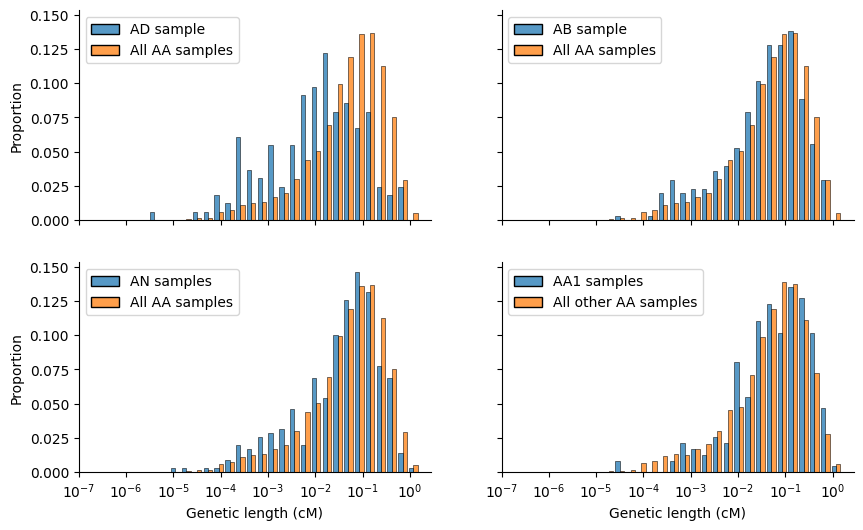

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

plot_cm_diffs(
    ["AD"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AD sample",
    label_legend2 = "All AA samples",
    ax = axs[0,0],
)

plot_cm_diffs(
    ["AB"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AB sample",
    label_legend2 = "All AA samples",
    ax = axs[0,1],
)


plot_cm_diffs(
    ["AN-s1", "AN-s2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AN samples",
    label_legend2 = "All AA samples",
    ax = axs[1,0],
)


plot_cm_diffs(
    ["AA1-s1", "AA1-s2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA1-s1", "AA1-s2"]],
    label_legend1 = "AA1 samples",
    label_legend2 = "All other AA samples",
    ax = axs[1,1],
)

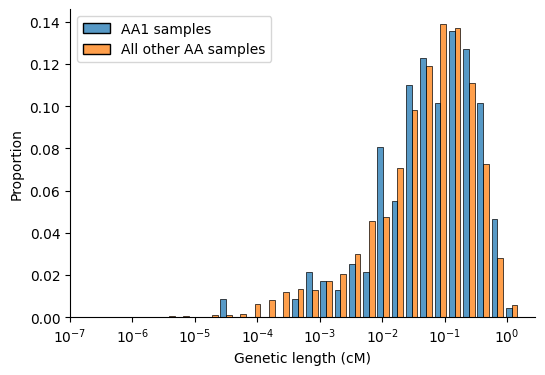

In [18]:
plot_cm_diffs(
    ["AA1-s1", "AA1-s2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA1-s1", "AA1-s2"]],
    label_legend1 = "AA1 samples",
    label_legend2 = "All other AA samples",
)

## Big transparent plot?

In [ ]:
def get_data(label_list, name):
    sample_ids = [k for k,v in sample_id_to_paper_label.items() if v in label_list]
    x = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids))["CO_active_interval_crossover_prob"] * 1e2), name=name)
    return x

fig, ax = plt.subplots(figsize=(8, 6))

data = [
#    get_data(["AA1-s1", "AA1-s2"], "AA1 samples"),
    get_data(
        [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA1-s1", "AA1-s2"]],
        "All other AA samples",
    ),
    get_data(["AN-s1", "AN-s2"], "AN samples"),
    get_data(["AB"], "AB"),
    get_data(["AD"], "AD"),
]

sns.histplot(
    data = data,
    bins=np.linspace(-5.5, 0.2, 25), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    #palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
# ax.legend(
#     ax.get_legend().legend_handles, 
#     ["CO reads", "NCO reads", "All reads"], 
#     loc="upper left",
# );

ax.spines[['right', 'top']].set_visible(False)

# *** Pretty plot for differences

In [ ]:
ax = inference.plot_boxplots_samples(
    CO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-4, 1),
    label_to_color={
        "AB": CO_color,
        "AD": CO_color,
        "AA1-s1": CO_color,
        "AA1-s2": CO_color,
    }
);


# DSBs

## Overall rates

### A/A

In [ ]:
print("Fraction of CO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("high_quality_classification_class") == "CO")
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

In [ ]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                    
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

In [ ]:
print("Fraction of CO reads with motif in recombining region:", (CO_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                            
    .select(
        (pl.col("grch38_recombining_interval_start_pos") <= pl.col("AA_motif_center_pos")) &
        (pl.col("grch38_recombining_interval_end_pos") > pl.col("AA_motif_center_pos"))
    )
    .mean().item(0,0)
))

## Overall distances to motif center

### A/A

In [ ]:
xs, H = inference.calculate_motif_distance_histogram(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold = 300,
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);

plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");
plt.xlabel("Distance to motif (bp)");
plt.ylabel("Proportion");

In [ ]:
H[len(H)//2:].sum()

In [ ]:
np.sum(xs*H)

In [ ]:
%%time
inference.motif_distance_histogram_symmetry_permutation_testing(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    n_perms=1000,
    grch38_recombining_interval_threshold = 300,
    stat = "max_abs",
)

## Distance to motif centers, per sample

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), tqdm.tqdm(sample_id_order)):
    xs, H = inference.calculate_motif_distance_histogram(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500,500)
    ax.set_ylim(0, 0.0006);

fig.tight_layout()

# Compare distance to motif between samples, in COs

In [ ]:
rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1) & (pl.col("high_quality_classification_class") == "CO"))
        ),
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2) & (pl.col("high_quality_classification_class") == "CO"))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=100,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

In [ ]:
pairwise_motif_dists_co_df.sort("perm_pval").head()

# Compare DSB signal strengths between COs

In [ ]:
sample_id_to_AA_heats = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter(pl.col("grch38_reference_start").is_not_null())           
        .filter((pl.col("sample_id") == sample_id) & (pl.col("high_quality_classification_class") == "CO"))
    )
    heats = sdf["AA_heat"].fill_null(0)
    sample_id_to_AA_heats[sample_id] = heats.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    heats_1 = sample_id_to_AA_heats[sample_id1]
    heats_2 = sample_id_to_AA_heats[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(heats_1), 
            len(heats_2),
            scipy.stats.ks_2samp(heats_1, heats_2).pvalue,
            inference.permutation_testing([[heats_1, heats_2]], 1000),
            inference.permutation_testing([[heats_1[heats_1>0], heats_2[heats_2>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_1==0).sum(), (heats_1!=0).sum()],
                 [(heats_2==0).sum(), (heats_2!=0).sum()]],
            ).pvalue,
        ]
    )
    
pairwise_AA_heats_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

In [ ]:
pairwise_AA_heats_co_df.sort("heats_AD_perm_pvalue")

## Matrix

In [ ]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
    annot=True,
    fmt=".2f",
    square=True,
);

plt.title("AD perm pvalues");

In [ ]:
mat = []
for sample_id1 in sample_presentation_order[:-1]:
    row = []
    for sample_id2 in sample_presentation_order[:-1]:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_fisher_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
labels = [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]
mat = pd.DataFrame(mat, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
    annot=True,
    fmt=".2f",
    square=True,    
);

plt.title("Fisher's exact pvalues");

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [(sample_id_to_AA_heats[s]>0).mean() for s in sample_presentation_order[:-1]]
cis = [statsmodels.stats.proportion.proportion_confint(
    (sample_id_to_AA_heats[s]>0).sum(),
    len(sample_id_to_AA_heats[s]),
    method="beta",
) for s in sample_presentation_order[:-1]]
    


ax.errorbar(
    x = np.arange(len(sample_presentation_order[:-1])),
    y = mns,
    yerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    ],
    fmt=".-",
    ms=20,
    
);
ax.set_xticks(
    ticks = np.arange(len(sample_id_order)), 
    labels=[sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]], 
    rotation=45
);
ax.set_ylabel("Fraction of CO reads with DSB");

### Sample vs. rest

In [ ]:
def test_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        xx = sample_id_to_AA_heats[sample_id]
        sx = (xx>0).sum()
        yy = np.concatenate([sample_id_to_AA_heats[s] for s in sample_ids if s != sample_id])
        sy = (yy>0).sum()
        
        pval = scipy.stats.fisher_exact(
            [[sx, len(xx)-sx], [sy, len(yy)-sy]]
        ).pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, sx/len(xx), sy/len(yy), pval])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")
    return df
    

In [ ]:
test_fishers_exact_one_vs_rest(sample_ids)

In [ ]:
test_fishers_exact_one_vs_rest([s for s in sample_ids if sample_id_to_paper_label[s] not in ["AD", "AA1-s1", "AA2-t1"]])

In [ ]:
def test_combined_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        pvals = (pairwise_AA_heats_co_df
            .filter((pl.col("sample_id1") == sample_id) | (pl.col("sample_id2") == sample_id))
            ["heats_fisher_pvalue"]
        )
        
        comb_fisher = scipy.stats.combine_pvalues(pvals, method="fisher").pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, comb_fisher])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")
    return df
    
    

In [ ]:
test_combined_fishers_exact_one_vs_rest(sample_ids)

In [ ]:
test_combined_fishers_exact_one_vs_rest([s for s in sample_ids if sample_id_to_paper_label[s] not in ["AD", "AA1-s1", "AA2-t1"]])

## Look at some examples

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD50508f"
sample_id2 = "PD50521e"

pval = pairwise_AA_heats_co_df.filter(
    ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
    ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
)["heats_AD_perm_pvalue"].item(0)

sns.histplot(
    [
        pd.Series(sample_id_to_AA_heats[sample_id1], name=sample_id1),
        pd.Series(sample_id_to_AA_heats[sample_id2], name=sample_id2),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
plt.title(f"AD perm pval = {pval}");


# Pratto et al. DSBs

In [ ]:
pratto_df = pd.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/pratto_2014_hotspots.tsv",
    delim_whitespace = True,
    comment = "#",
)

In [ ]:
intersection_df = (
    pl.from_dataframe(
        pybedtools.BedTool.from_dataframe(
            CO_df
                .select("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos", "read_name")
                .sort("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos")
                .to_pandas()
        ).intersect(
            pybedtools.BedTool.from_dataframe(
                pratto_df[["chrom", "start", "end", "AA1_strength"]].sort_values(["chrom", "start"])
            ),
            wao=True,
        )
        .to_dataframe()
    )
    .with_columns(
        AA1_heat_signal = pl.col("thickEnd").cast(pl.Int32, strict=False)
    )
    .select(
        "chrom", 
        "start", 
        "end", 
        pl.col("name").alias("read_name"), 
        pl.col("itemRgb").alias("n_intersect"), 
        "AA1_heat_signal",
        (pl.col("end") - pl.col("start")).alias("n_total")
    )
)

pratto_AA1_df = (intersection_df
    .with_columns(times = pl.col("AA1_heat_signal") * pl.col("n_intersect"))
    .group_by("read_name", "n_total")
    .agg(pl.col("times").sum())
    .with_columns(AA1_heat_average = pl.col("times") / pl.col("n_total"))
    .select("read_name", "AA1_heat_average")
)

In [ ]:
intersection_df = (
    pl.from_dataframe(
        pybedtools.BedTool.from_dataframe(
            CO_df
                .select("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos", "read_name")
                .sort("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos")
                .to_pandas()
        ).intersect(
            pybedtools.BedTool.from_dataframe(
                pratto_df[["chrom", "start", "end", "AA2_strength"]].sort_values(["chrom", "start"])
            ),
            wao=True,
        )
        .to_dataframe()
    )
    .with_columns(
        AA2_heat_signal = pl.col("thickEnd").cast(pl.Int32, strict=False)
    )
    .select(
        "chrom", 
        "start", 
        "end", 
        pl.col("name").alias("read_name"), 
        pl.col("itemRgb").alias("n_intersect"), 
        "AA2_heat_signal",
        (pl.col("end") - pl.col("start")).alias("n_total")
    )
)

pratto_AA2_df = (intersection_df
    .with_columns(times = pl.col("AA2_heat_signal") * pl.col("n_intersect"))
    .group_by("read_name", "n_total")
    .agg(pl.col("times").sum())
    .with_columns(AA2_heat_average = pl.col("times") / pl.col("n_total"))
    .select("read_name", "AA2_heat_average")
)

In [ ]:
pairwise_pratto_aa1_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.join(pratto_AA1_df, on="read_name", how="left").fill_null(0),
    "AA1_heat_average",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
pairwise_pratto_aa2_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.join(pratto_AA2_df, on="read_name", how="left").fill_null(0),
    "AA2_heat_average",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
pairwise_pratto_aa1_df.sort("AD_perm_pvalue").head(10)

In [ ]:
pairwise_pratto_aa2_df.sort("AD_perm_pvalue").head(10)

In [ ]:
inference.plot_pairwise_results(
    pairwise_pratto_aa1_df,
    sample_presentation_order[:-1],
)

In [ ]:
inference.plot_pairwise_results(
    pairwise_pratto_aa2_df,
    sample_presentation_order[:-1],
)

In [ ]:
sample_id_to_has_AA1_frac = dict(
    (CO_df
        .join(pratto_AA1_df, on="read_name", how="left").fill_null(0)
        .group_by("sample_id")
        .agg((pl.col("AA1_heat_average")>0).cast(pl.Int32).mean().alias("has_AA1_heat"))
    )
    .rows()
)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [sample_id_to_has_AA1_frac[s] for s in sample_presentation_order[:-1]]
# cis = [statsmodels.stats.proportion.proportion_confint(
#     (sample_id_to_AA_heats[s]>0).sum(),
#     len(sample_id_to_AA_heats[s]),
#     method="beta",
# ) for s in sample_id_order]
    


ax.plot(
    np.arange(len(sample_id_order)),
    mns,
    # yerr = [
    #     [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
    #     [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    # ],
    '.-',
    #fmt=".-",
    ms=20,
    
);
ax.set_xticks(ticks = np.arange(len(sample_presentation_order[:-1])), labels=sample_presentation_order[:-1], rotation=45);
ax.set_ylabel("Fraction of CO reads with DSB");

# Distance to telomeres

$Pr(dist|detected) \propto Pr(detected|dist)Pr(dist)$

$Pr(dist) \approx $ (num of reads in dist)/(num total reads) \propto (num of reads in dist)

$Pr(detected|dist) \approx \frac{1}{\text{num of reads in dist}}\sum_{read\ in\ dist}{Pr(detected|read)}$ \Rightarrow

$Pr(dist|detected) \propto \sum_{read\ in\ dist}{Pr(detected|read)}$ (???)

In [ ]:
exp_df = (dense_reads_with_detection_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .agg(pl.col("CO_active_interval_crossover_prob").sum().alias("exp"))
    .sort("rounded_grch37_reference_start")
    .with_columns(
        exp = pl.col("exp") / pl.col("exp").sum()
    )
)

obs_df = (CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .len()
    .sort("rounded_grch37_reference_start")
    .with_columns(
        obs = pl.col("len") / pl.col("len").sum()
    )
)

n_total = len(CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
)

low_ci, high_ci = statsmodels.stats.proportion.proportion_confint(
    obs_df["len"], n_total, alpha=0.05, method='beta'
)

plt.scatter(
    exp_df["rounded_grch37_reference_start"],
    exp_df["exp"],
    label="Expected",
)

plt.errorbar(
    x=obs_df["rounded_grch37_reference_start"],
    y=obs_df["obs"],
    yerr=[obs_df["obs"]-low_ci, high_ci-obs_df["obs"]],
    color="C1",
    label="Observed",
    fmt='-o',
    lw=0.5,
)

plt.legend();
plt.title("COs near telomeres");

# ENCODE H3K4me3

In [ ]:
pairwise_co_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
pairwise_co_signals_df.sort("AD_perm_pvalue").head()

In [ ]:
inference.plot_pairwise_results(pairwise_co_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [ ]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [42]:
def plot_h3k4_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids1))["H3K4me3_signal_mean"]), name=label_legend1)
    x2 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids2))["H3K4me3_signal_mean"]), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins = np.linspace(-1, 1.5, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("H3K4me4 signal average across read");
    ax.set_xticks(
        ticks = np.arange(-1, 2, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-1, 2, 1)],
    );

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


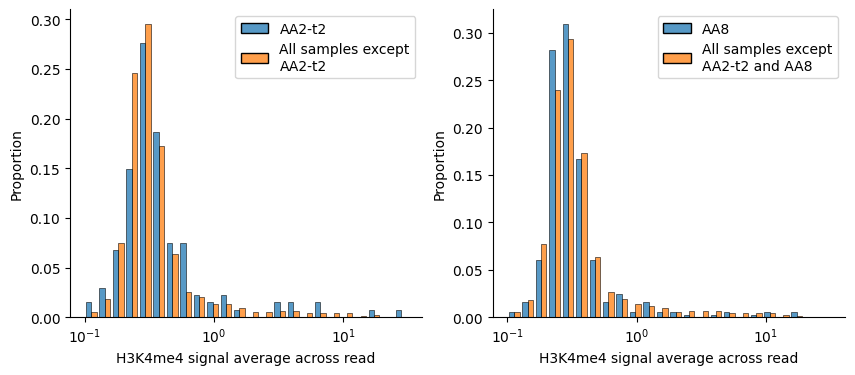

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_h3k4_diffs(
    ["AA2-t2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA2-t2"]],
    label_legend1 = "AA2-t2",
    label_legend2 = "All samples except\nAA2-t2",
    ax = axs[0]
)

plot_h3k4_diffs(
    ["AA8"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA8", "AA2-t2"]],
    label_legend1 = "AA8",
    label_legend2 = "All samples except\nAA2-t2 and AA8",
    ax = axs[1]
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AA2-t2"]],
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
plot_h3k4_diffs(
    ["AA8"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA2-t2", "AA8"]],
    label_legend1 = "AA8",
    label_legend2 = "All other samples except AA2-t2",
)

In [ ]:
ax = inference.plot_boxplots_samples(
    CO_df,
    "H3K4me3_signal_mean",
    xlabel = "H3K4me3_signal_mean",
    take_log10=True,
    figsize=(4, 6),
    #ticks = np.arange(-1, 1),
    label_to_color={
        "AA6": CO_color,
        "AA8": CO_color,
        "AA2-t2": CO_color,
    }
);


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "95619"
other_focal_sample_id = "7899"

sns.histplot(
    [
        # pd.Series(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"].log10(), 
        #           name="All others"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"].log10(), 
                  name=sample_id_to_paper_label[focal_sample_id]),        
        pd.Series(CO_df.filter(pl.col("sample_id") == other_focal_sample_id)["H3K4me3_signal_mean"].log10(), 
                  name=sample_id_to_paper_label[other_focal_sample_id]),
    ], 
    bins=np.linspace(-1,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
inference.get_sample_vs_all_tests(
    sample_ids,
    CO_df,
    dense_reads_with_detection_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
    subsample_fraction = 0.001,
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD50521e"

sns.histplot(
    [
        pd.Series(dense_reads_with_detection_df["H3K4me3_signal_mean"][::100], name="All reads"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD50519d"

sns.histplot(
    [
        pd.Series(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"], 
                  name="All others"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


# ENCODE CTCF

In [ ]:
pairwise_co_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
)

In [ ]:
pairwise_co_signals_df.sort("AD_perm_pvalue")

In [ ]:
inference.plot_pairwise_results(pairwise_co_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [ ]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    CO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
inference.get_sample_vs_all_tests(
    sample_ids,
    CO_df,
    dense_reads_with_detection_df[::100],
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD46180c"

sns.histplot(
    [
        pd.Series(dense_reads_with_detection_df["CTCF_signal_mean"][::100], name="All reads"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["CTCF_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,2,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
def dropnan(x):
    return x[~np.isnan(x)]

In [ ]:
focal_sample_id = "PD50519d"

scipy.stats.ttest_ind(
    dropnan(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"].to_numpy()),
    dropnan(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"].to_numpy()),
)

In [ ]:
inference.plot_histograms_samples(
    CO_df,
    "CTCF_signal_mean",
    dense_reads_with_detection_df,
    bins = np.linspace(-0.8, 0.4, 25),
    ylim_max = 0.3,
    xlabel = "",
    take_log10=True,
);